In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pathlib import Path
import os
import torch.utils.data as data
import matplotlib.pyplot as plt


In [2]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import save_image
#from torchnet.meter import AverageValueMeter
import torch.backends.cudnn as cudnn

In [3]:
data_dir = Path("/home/michael/Desktop/projects/ROAR/data/output")
center_depth_dir = data_dir / "front_depth"
veh_state_dir = data_dir / "vehicle_state"

center_depth_paths = [p for p in sorted(center_depth_dir.glob("*.npy", ), key=os.path.getmtime)]
veh_state_paths = [p for p in sorted(veh_state_dir.glob("*.npy", ), key=os.path.getmtime)]
print(f"Found { len(center_depth_paths)} data points")

Found 102172 data points


(array([[<AxesSubplot:title={'center':'steering'}>]], dtype=object),
             throttle       steering
 count  102176.000000  102176.000000
 mean        0.577268      -0.007161
 std         0.475320       0.113447
 min         0.000000      -1.000000
 25%         0.000000      -0.073310
 50%         1.000000      -0.007634
 75%         1.000000       0.063397
 max         1.000000       1.000000)

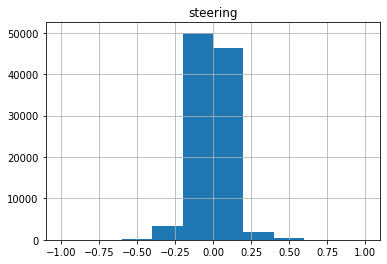

In [4]:
throttles, steerings = [], []
for st_path in veh_state_paths:
    array = np.load(st_path)
    throttles.append(array[-2])
    steerings.append(array[-1])
df = pd.DataFrame(
    data={"throttle":throttles, "steering":steerings}
)
df.hist("steering"), df.describe()

In [5]:
from utils import depth2colorjet, random_flip, crop_roi
import cv2
class CarDataset(data.Dataset):
    def __init__(self, X, y, img_width=64, img_height=64, should_take_roi=False, roi_min_height=30):
        self.X = X
        self.y = y
        self.img_width=img_width
        self.img_height=img_height
        self.should_take_roi = should_take_roi
        self.roi_min_height = roi_min_height
        
    def __getitem__(self, index):
        img_path = self.X[index]
        veh_state_path = self.y[index]
        steering_angle = np.load(veh_state_path)[-1]
        img = np.load(img_path)
#         color_jet_rgb = depth2colorjet(img)
        img = cv2.resize(img, dsize=(self.img_width, self.img_height))
        if self.should_take_roi:
            img = img[30:self.img_width, :]
        
        # generate random noise to the image
        img, steering_angle = random_flip(img, steering_angle)
        return img, steering_angle
    
    def __len__(self):
        return len(self.X)

    

In [6]:
car_dataset = CarDataset(X=center_depth_paths, y=veh_state_paths)


(<matplotlib.image.AxesImage at 0x7f7e137aaaf0>, 0.06670547276735306)

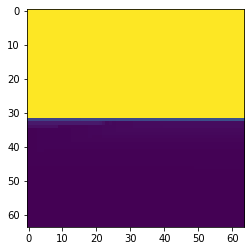

In [7]:
color_jet_depth, angle = car_dataset[100]
plt.imshow(color_jet_depth), angle

In [8]:
class CarModel(nn.Module):
    def __init__(self):
        super(CarModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 24, 5),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(24, 48, 5),
            nn.ELU(),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(48, 96, 5),
            nn.ELU(),
            nn.MaxPool2d(2),
            nn.Dropout(p=0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=96*4*4,out_features=100),
            nn.ELU(),
            nn.Linear(in_features=100, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        )

    def forward(self, input):
        input = torch.reshape(input, (1, 1, 64, 64))
        output = self.conv_layers(input)
        output = output.flatten()
        output = self.linear_layers(output)
        return output   

In [9]:
def toTensor(data, use_cuda, device=None):
    img, target = data
    img, target = x_np = torch.from_numpy(img).float(), torch.from_numpy(np.array([target])).float()
    if use_cuda:
        img, target = img.to(device), target.to(device)
    return img, target

In [10]:

def train(epoch, net, dataloader, optimizer, criterion, use_cuda, device=None, save_dir=Path(".")):
    min_error = 1000000
    save_dir.mkdir(exist_ok=True, parents=True)
    if use_cuda:
        net.to(device)
    net.train()
    train_loss = 0
    for batch_idx, data in enumerate(dataloader):
        optimizer.zero_grad()
        img, steering_angle = toTensor(data, use_cuda, device)
        output = net(img)
        loss = criterion(output, steering_angle)
        loss.backward()
        optimizer.step()
        train_loss += loss.data.item()
        if batch_idx % 1000 == 0:
            print(f'    Batch: {batch_idx} --> Loss: {train_loss / (batch_idx+1)}')
        
        if train_loss / (batch_idx+1) < min_error:
            print("          Newest lowest steer MSE: {:.4f}".format(train_loss / (batch_idx+1)))
            torch.save(net, save_dir / "best_model.h5")
            min_error = train_loss / (batch_idx+1)
    
    torch.save(net, save_dir / "model.h5")

        

In [11]:
net = CarModel()
optimizer = optim.Adam(net.parameters(), lr=1e-5)
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

In [ ]:
for epoch in range(0, 10):
    print(f"Epoch {epoch}")
    train(epoch, net, car_dataset, optimizer, criterion, use_cuda, device=device, save_dir=Path("./data"))

Epoch 0
    Batch: 0 --> Loss: 0.008364888839423656
          Newest lowest steer MSE: 0.0084
          Newest lowest steer MSE: 0.0067
          Newest lowest steer MSE: 0.0061
          Newest lowest steer MSE: 0.0052
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0051
          Newest lowest steer MSE: 0.0047
          Newest lowest steer MSE: 0.0047
          Newest lowest steer MSE: 0.0043
          Newest lowest steer MSE: 0.0041
          Newest lowest steer MSE: 0.0038
          Newest lowest steer MSE: 0.0036
          Newest lowest steer MSE: 0.0035
          Newest lowest steer MSE: 0.0033
          Newest lowest steer MSE: 0.0032
          Newest lowest steer MSE: 0.0031
          Newest lowest steer MSE: 0.0029
          Newest lowest steer MSE: 0.0028
          Newest lowest steer MSE: 0.0027
          Newest lowest steer MSE: 0.0026
          Newest lowest steer MSE: 0.0025
          Newest lowest steer MSE: 0.0024
          Newest lowest 